# Introduction to Likelihood 2 fitting SI model

In [17]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.stats import binom
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse



In [18]:
# define the parameters 
def disease_params(Beta=0.9, alpha=8, progRt=(1/10)*4, birthRt=0.03, deathRt=1/60):
    return {
        'Beta': Beta,
        'alpha': alpha,
        'progRt': progRt,
        'birthRt': birthRt,
        'deathRt': deathRt
    }

# Initialize the parameters
params = disease_params()
params

{'Beta': 0.9,
 'alpha': 8,
 'progRt': 0.4,
 'birthRt': 0.03,
 'deathRt': 0.016666666666666666}

In [19]:
# Define the SI ODE model
def SI_model(y, t, params):
    S, I1, I2, I3, I4, CI, CD = y
    I = I1 + I2 + I3 + I4
    N = S + I
    transmissionCoef = params['Beta'] * np.exp(-params['alpha'] * I / N) # Infectious contact rate
    
    dS = params['birthRt'] * N - params['deathRt'] * S - transmissionCoef * S * I / N
    dI1 = transmissionCoef * S * I / N - params['progRt'] * I1 - params['deathRt'] * I1
    dI2 = params['progRt'] * I1 - params['progRt'] * I2 - params['deathRt'] * I2
    dI3 = params['progRt'] * I2 - params['progRt'] * I3 - params['deathRt'] * I3
    dI4 = params['progRt'] * I3 - params['progRt'] * I4 - params['deathRt'] * I4
    dCI = transmissionCoef * S * I / N
    dCD = params['progRt'] * I4
    
    return [dS, dI1, dI2, dI3, dI4, dCI, dCD]


In [20]:
# Simulate the epidemic
def simulate_epidemic(init, t_seq, params):
    result = odeint(SI_model, init, t_seq, args=(params,))
    I = result[:, 1:5].sum(axis=1)
    N = result[:, 0] + I
    P = I / N #prevelance 
    return {'time': t_seq, 'P': P}

# Initial values and time sequence
initPrev = np.exp(-7)
tseqMonth = np.arange(1976, 2023, 1/12)
init = [1-initPrev, initPrev, 0, 0, 0, 0, 0]

# Simulate the epidemic with true parameters
sim_data = simulate_epidemic(init, tseqMonth, params)

for time, prevalence in zip(sim_data['time'], sim_data['P']):
    print(f"Time: {time}, Prevalence: {prevalence}")

Time: 1976.0, Prevalence: 0.0009118819655545162
Time: 1976.0833333333333, Prevalence: 0.0009798472053080662
Time: 1976.1666666666665, Prevalence: 0.0010528045503931617
Time: 1976.2499999999998, Prevalence: 0.001131137984809135
Time: 1976.333333333333, Prevalence: 0.0012152285987689932
Time: 1976.4166666666663, Prevalence: 0.0013054864560100292
Time: 1976.4999999999995, Prevalence: 0.001402347911492495
Time: 1976.5833333333328, Prevalence: 0.0015062777430325765
Time: 1976.666666666666, Prevalence: 0.001617771346391636
Time: 1976.7499999999993, Prevalence: 0.0017373564727011796
Time: 1976.8333333333326, Prevalence: 0.0018655960691964602
Time: 1976.9166666666658, Prevalence: 0.002003089699321744
Time: 1976.999999999999, Prevalence: 0.002150471466116958
Time: 1977.0833333333323, Prevalence: 0.0023084132813317323
Time: 1977.1666666666656, Prevalence: 0.002477633465060302
Time: 1977.2499999999989, Prevalence: 0.002658888525117565
Time: 1977.3333333333321, Prevalence: 0.002852985762315945
Tim

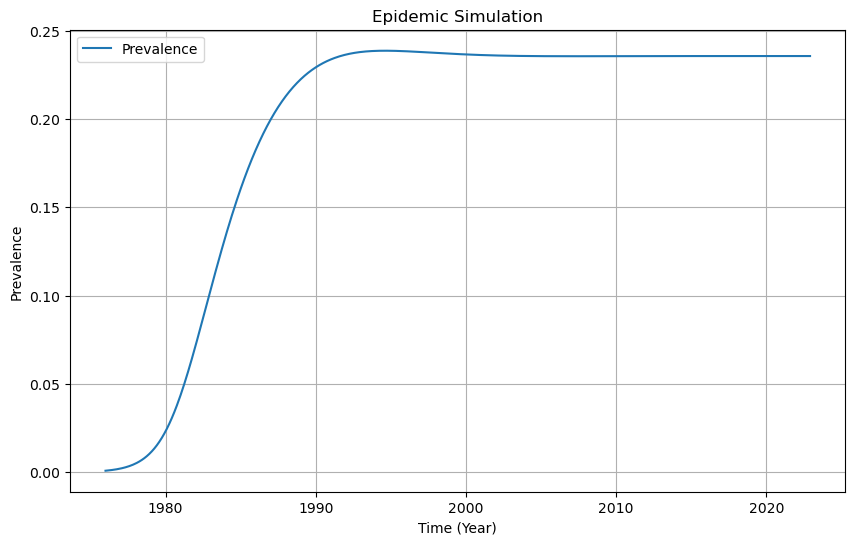

In [21]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sim_data['time'], sim_data['P'], label='Prevalence')
plt.xlabel('Time (Year)')
plt.ylabel('Prevalence')
plt.title('Epidemic Simulation')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
def sample_epidemic(sim_data, sample_dates, num_samples):
    # Convert sample_dates to a numpy array

    sample_dates = np.array(sample_dates)

    
    # Find closest matching times in sim_data
    available_times = sim_data['time']
    closest_times = [available_times[np.argmin(np.abs(available_times - date))] for date in sample_dates]
    
    # Calculate prevalence at the closest available times
    prev_at_sample_times = [sim_data['P'][available_times == time][0] for time in closest_times]

    # Draw binomial samples based on prevalence
    num_pos = np.random.binomial(num_samples, prev_at_sample_times)
    sample_prev = num_pos / num_samples

     # Calculate binomial confidence intervals
    lci = [binom.interval(0.95, n, p)[0] / n for n, p in zip(num_samples, sample_prev)]
    uci = [binom.interval(0.95, n, p)[1] / n for n, p in zip(num_samples, sample_prev)]
    
    return pd.DataFrame({
        'time': closest_times,
        'numPos': num_pos,
        'numSamp': num_samples,
        'sampPrev': sample_prev,
        'lci': lci,
        'uci': uci
    })
sample_dates = np.arange(1980, 2010, 3)
num_samples = np.full(len(sample_dates), 80)

    
# Example call
my_data = sample_epidemic(sim_data, sample_dates, num_samples)


In [23]:
my_data

,time,numPos,numSamp,sampPrev,lci,uci
0,1980.0,1,80,0.0125,0.0000,0.0375
1,1983.0,12,80,0.1500,0.0750,0.2375
2,1986.0,12,80,0.1500,0.0750,0.2375
3,1989.0,16,80,0.2000,0.1125,0.2875
4,1992.0,16,80,0.2000,0.1125,0.2875
5,1995.0,22,80,0.2750,0.1750,0.3750
6,1998.0,22,80,0.2750,0.1750,0.3750
7,2001.0,18,80,0.2250,0.1375,0.3250
8,2004.0,21,80,0.2625,0.1750,0.3625
9,2007.0,22,80,0.2750,0.1750,0.3750


In [24]:
# Define the negative log-likelihood function
def nllikelihood(params, obs_data, init, t_seq):
    sim_data = simulate_epidemic(init, t_seq, params)
    matched_time = np.isin(sim_data['time'], obs_data['time'])
    prob = sim_data['P'][matched_time]
    nulls = - binom.logpmf(obs_data['numPos'] , obs_data['numSamp'], prob)
    return  np.sum(nulls)

true_null = nllikelihood(params, my_data, init, tseqMonth)
    

# Log-likelihood for true parameters


In [25]:
# Define the optimization function
def objFXN(fit_params, fixed_params, obs_data, init, t_seq):
    params = fixed_params.copy()
    params['beta'] = np.exp(fit_params[0])
    params['alpha'] = np.exp(fit_params[1])
    return nllikelihood(params, obs_data, init, t_seq)
    

    

# Initial guesses for the parameters
guess_params = np.log([5, 8])
    


result_nm = minimize(objFXN, guess_params, args=(params, my_data, init, tseqMonth),
                     method='BFGS', options={'maxiter': 150}) # (Broyden-Fletcher-Goldfarb-Shanno)


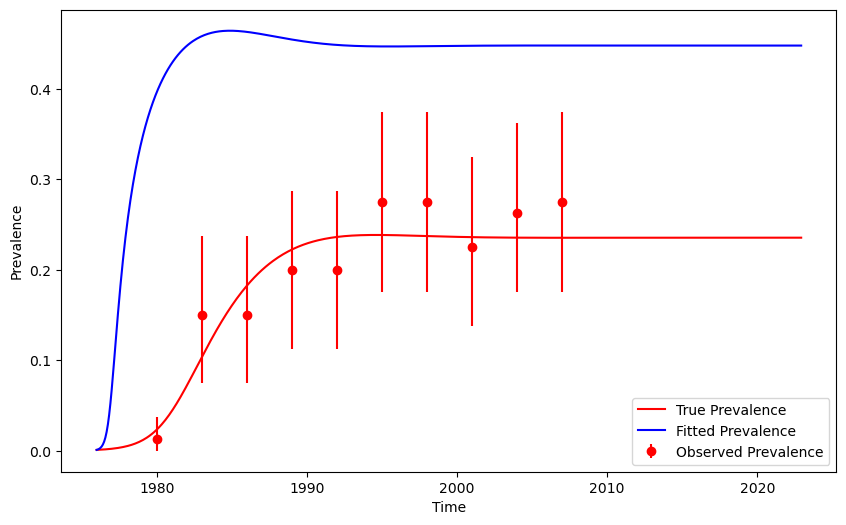

In [26]:
def plot_results(sim_data, fit_data, my_data):
    plt.figure(figsize=(10, 6))
    plt.plot(sim_data['time'], sim_data['P'], 'r-', label='True Prevalence')
    plt.plot(fit_data['time'], fit_data['P'], 'b-', label='Fitted Prevalence')
    plt.errorbar(my_data['time'], my_data['sampPrev'], yerr=[my_data['sampPrev']-my_data['lci'], my_data['uci']-my_data['sampPrev']],
                 fmt='ro', label='Observed Prevalence')
    plt.xlabel('Time')
    plt.ylabel('Prevalence')
    plt.legend()
    plt.show()

# Simulate epidemic with MLE fitted parameters
fitted_params = disease_params(Beta=np.exp(result_nm.x[0]), alpha=np.exp(result_nm.x[1]))
fit_data = simulate_epidemic(init, tseqMonth, fitted_params)

# Plot the results
plot_results(sim_data, fit_data, my_data)
